# Convolutional LSTM for action prediction

- keep track of best validation value + Save checkpoints with information (autosave)
- clean naming (of how models are saved, configs are saved, runs are called)
- confusion matrix of result / comparison with baseline LSTM (that only takes in actions)
- wandb/ tensorboard integration (also for gradient information?)
- hydra integration for hyperparameters?

### Imports

In [1]:
import pickle
import hydra
import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torchinfo import summary

from tqdm.auto import tqdm

from omegaconf import OmegaConf

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


### Hyperparameters

In [2]:
# input size is 960 or 1
train_imgs = True
save_infos = False

# preprocessing
seq_length = 20
training_set_size = 0.67

# lstm configuration
hidden_size = 20
num_layers = 1
num_classes = 4
save_model = False

# training
num_epochs = 2000
learning_rate = 0.01
optimizer_type = "Adam"

In [3]:
if train_imgs:
    input_size = 960
else:
    input_size = 1

if num_classes == 1:
    hot_encoding = False
elif num_classes == 4:
    hot_encoding = True

In [4]:
# hydra integration for hyperparameters
hydra.core.global_hydra.GlobalHydra.instance().clear()

hydra.initialize(
    version_base=None, config_path="conf"
)  # Assume the configuration file is in the current folder
cfg = hydra.compose(config_name="config")
# Can be used in the following way: cfg.params.learning_rate
print(OmegaConf.to_yaml(cfg))

params:
  train_imgs: false
  save_infos: false
  dataset_name: None
  seq_length: 20
  batch_size: 128
  training_set_size: 0.67
  hidden_size: 20
  num_layers: 1
  num_classes: 4
  input_size: 1
  num_epochs: 2000
  learning_rate: 0.01
  optimizer_type: Adam
  save_model: false
  save_plots: false



### Load datasets

In [5]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

### Preprocess data

In [6]:
# preprocess with sequence length
x_acts, x_imgs, y_acts = preprocess.sliding_windows(
    oracle_data, seq_length, hot_encoding
)
# data, train, test split
data, train, test = preprocess.split(x_acts, x_imgs, y_acts, training_set_size)
dataX_acts, dataX_imgs, dataY_acts = data
trainX_acts, trainX_imgs, trainY_acts = train
testX_acts, testX_imgs, testY_acts = test

### Initialize models

In [7]:
cnn = nets.CNN(seq_length)
lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

if train_imgs:
    features = cnn(trainX_imgs)
else:
    features = trainX_acts

outputs = lstm(features)

print("CNN input shape:", trainX_imgs.size())
print("CNN output shape:", features.size())

print("LSTM input shape:", features.size())
print("LSTM output shape:", outputs.size())

print("Label shape:", trainY_acts.size())

print("SUMMARY CNN \n", summary(cnn, trainX_imgs.size()), "\n")
# print('SUMMARY LSTM \n', summary(lstm, (outputs.size(), ((2, 10), (2, 10,)))))

CNN input shape: torch.Size([786, 20, 3, 32, 32])
CNN output shape: torch.Size([786, 20, 960])
LSTM input shape: torch.Size([786, 20, 960])
LSTM output shape: torch.Size([786, 4])
Label shape: torch.Size([786, 4])
SUMMARY CNN 
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [786, 20, 960]            --
├─Conv2d: 1-1                            [15720, 20, 28, 28]       1,520
├─Conv2d: 1-2                            [15720, 40, 24, 24]       20,040
├─MaxPool2d: 1-3                         [15720, 40, 12, 12]       --
├─Conv2d: 1-4                            [15720, 60, 8, 8]         60,060
├─MaxPool2d: 1-5                         [15720, 60, 4, 4]         --
Total params: 81,620
Trainable params: 81,620
Non-trainable params: 0
Total mult-adds (G): 260.61
Input size (MB): 193.17
Forward/backward pass size (MB): 5352.35
Params size (MB): 0.33
Estimated Total Size (MB): 5545.84



### Tensorboard integrations

In [8]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
%tensorboard --logdir=runs

### Network training

In [9]:
# wandb and tensorboard integration
# write model summary/ parameter settings into runs folder

# track best validation value
# save model during training

# full batch training likely is too slow (?)
"""
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in DualInput_model.state_dict():
    print(param_tensor, "\t", DualInput_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
cnn = nets.CNN(seq_length)

print(trainX_imgs[0])
features = cnn(trainX_imgs)
print('features', features[0])
"""
# problem: with the imgs the loss does never decrease below 0.27

'\n# Print model\'s state_dict\nprint("Model\'s state_dict:")\nfor param_tensor in DualInput_model.state_dict():\n    print(param_tensor, "\t", DualInput_model.state_dict()[param_tensor].size())\n\n# Print optimizer\'s state_dict\nprint("\nOptimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])\n    \ncnn = nets.CNN(seq_length)\n\nprint(trainX_imgs[0])\nfeatures = cnn(trainX_imgs)\nprint(\'features\', features[0])\n'

In [10]:
def recode_values(outputs):

    # max threshold, absolut
    adopted_output = [
        abs(output.detach().cpu().numpy()[0])
        * (output.detach().cpu().numpy() >= max(output.detach().cpu().numpy()))
        for output in outputs
    ]
    # all values 0 or 1, make it a tensor again to make np.where work
    adopted_output = torch.FloatTensor(
        [list(np.where(variable > 0, 1, 0)) for variable in adopted_output]
    )
    # reverse the original coding to get a single int again
    adopted_output = [np.where(data == 1)[0][0] for data in adopted_output]  #

    return adopted_output

In [11]:
def compute_correct(new_data_predict, dataY_plot):
    new_dataY_plot = [np.where(r == 1)[0][0] for r in dataY_plot]
    counter = 0
    for i in range(len(new_data_predict)):
        if new_data_predict[i] == new_dataY_plot[i]:
            counter += 1
    return counter


def compute_acc(outputs, labels):
    outputs = recode_values(outputs)
    correct = compute_correct(outputs, labels)
    acc = correct / len(outputs)

    return acc

In [19]:
if train_imgs:
    params = list(cnn.parameters()) + list(lstm.parameters())
else:
    params = lstm.parameters()

# MSELoss - regression, CrossEntropyLoss for labels or BCEWithLogitsLoss
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.01

if optimizer_type == "Adam":
    optimizer = torch.optim.Adam(params, lr=learning_rate)
elif optimizer_type == "SGD":
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)

num_epochs = 500
train_imgs = True

# save current conf infos
if save_infos:
    local_time = str(datetime.datetime.now().isoformat())
    name = local_time + "_configs"
    OmegaConf.save(cfg, "runs/" + name)

with tqdm(total=num_epochs, unit=" Episode", desc="Progress") as pbar:

    # tracking results
    train_loss_lst, test_loss_lst = [], []
    train_acc_lst, test_acc_lst = [], []
    test_best_acc = 100
    writer = SummaryWriter()

    for epoch in range(num_epochs):

        with torch.no_grad():
            # choose training style
            if train_imgs:
                features = cnn(testX_imgs)
            else:
                features = testX_acts
            outputs = lstm(features)

            # loss
            loss_test = criterion(outputs, testY_acts)

            # compute train acc
            acc_test = compute_acc(outputs, testY_acts)

        # choose training style
        if train_imgs:
            features = cnn(trainX_imgs)  # forwarad pass of the cnn
        else:
            features = trainX_acts

        # forwarad pass of the lstm
        outputs = lstm(features)
        optimizer.zero_grad()  # zero the parameter gradients

        # loss + optimize
        loss_train = criterion(outputs, trainY_acts)
        loss_train.backward()
        optimizer.step()

        # compute train acc
        acc_train = compute_acc(outputs, trainY_acts)

        # display
        if epoch % (num_epochs / 10) == 0:
            epoch = (4 - len(str(epoch))) * str(0) + str(epoch)
            print(
                "Epoch: %s - Train Loss: %1.3f, Train Acc: %1.3g - Test Loss: %1.3f, Test Acc: %1.3g"
                % (epoch, loss_train.item(), acc_train, loss_test.item(), acc_test)
            )

        # collect tensorboard logs

        # collect plotting logs
        train_loss_lst.append(loss_train.item())
        test_loss_lst.append(loss_test.item())
        train_acc_lst.append(acc_train)
        test_acc_lst.append(acc_test)

        pbar.update(1)

    writer.close()
    print("Finished Training")

Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 0.993, Train Acc: 0.824 - Test Loss: 0.980, Test Acc: 0.845
Epoch: 0050 - Train Loss: 0.590, Train Acc: 0.824 - Test Loss: 0.542, Test Acc: 0.845
Epoch: 0100 - Train Loss: 0.587, Train Acc: 0.824 - Test Loss: 0.543, Test Acc: 0.845
Epoch: 0150 - Train Loss: 0.587, Train Acc: 0.824 - Test Loss: 0.543, Test Acc: 0.845
Epoch: 0200 - Train Loss: 0.586, Train Acc: 0.824 - Test Loss: 0.543, Test Acc: 0.845
Epoch: 0250 - Train Loss: 0.586, Train Acc: 0.824 - Test Loss: 0.542, Test Acc: 0.845
Epoch: 0300 - Train Loss: 0.586, Train Acc: 0.824 - Test Loss: 0.542, Test Acc: 0.845
Epoch: 0350 - Train Loss: 0.586, Train Acc: 0.824 - Test Loss: 0.542, Test Acc: 0.845
Epoch: 0400 - Train Loss: 0.586, Train Acc: 0.824 - Test Loss: 0.542, Test Acc: 0.845
Epoch: 0450 - Train Loss: 0.586, Train Acc: 0.824 - Test Loss: 0.542, Test Acc: 0.845
Finished Training


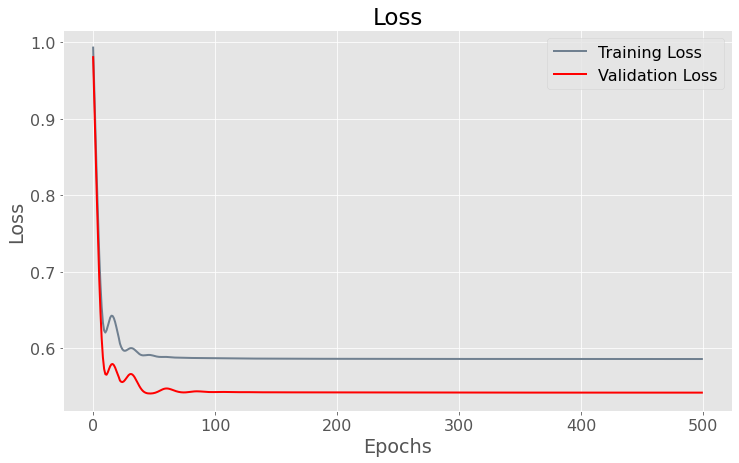

In [20]:
plot.plot_losses(train_loss_lst, test_loss_lst)

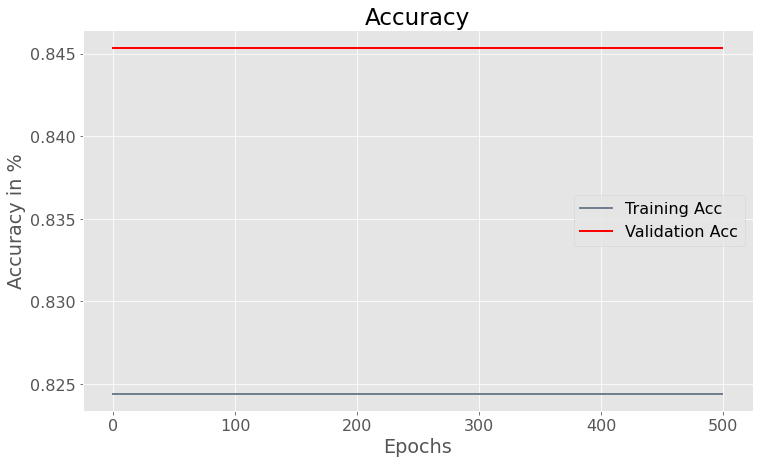

In [21]:
plot.plot_acc(train_acc_lst, test_acc_lst)

### Plotting results

In [15]:
def recode_one_hot(data_predict):
    new_data_predict = []
    for i in data_predict:
        if str(i) != "[0. 0. 0. 0.]":
            new_data_predict.append(np.where(i == 1)[0][0])
        else:
            new_data_predict.append(None)
    return new_data_predict

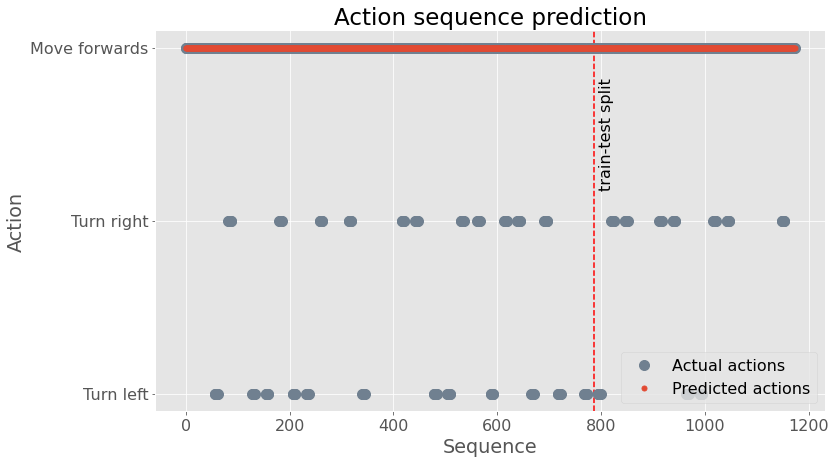

In [16]:
from matplotlib import pyplot as plt

lstm.eval()

if train_imgs:
    features = cnn(dataX_imgs)
    features = features  # + 0.01*trainX_acts
    train_predict = lstm(features)
else:
    train_predict = lstm(dataX_acts)

"""
t = Variable(torch.Tensor([0]))  # threshold
data_predict = (train_predict > t).float() * 1

new_data_predict = recode_one_hot(data_predict)
#data_predict = train_predict.data.numpy()
"""

new_data_predict = recode_values(train_predict)

dataY_plot = dataY_acts.data.numpy()
new_dataY_plot = [np.where(r == 1)[0][0] for r in dataY_plot]

with plt.style.context("ggplot"):
    plt.figure(figsize=(12, 7))
    plt.rcParams.update({"font.size": 16})
    plt.axvline(int(len(y_acts) * training_set_size), c="r", linestyle="--")
    plt.text(
        int(len(y_acts) * training_set_size) + 10,
        1.5,
        "train-test split",
        rotation=90,
        verticalalignment="center",
    )

    plt.plot(
        new_dataY_plot, "o", color="slategray", markersize=10, label="Actual actions"
    )
    plt.plot(new_data_predict, "o", markersize=5, label="Predicted actions")

    # locs, labels = plt.yticks()
    plt.yticks([0, 1, 2], ["Turn left", "Turn right", "Move forwards"])

    plt.legend(loc="lower right")
    plt.title("Action sequence prediction")
    plt.xlabel("Sequence")
    plt.ylabel("Action")
    plt.show()

In [17]:
# show that it isn't the LSTM that is broken

# and it would be weird if it would be the CNN architecture, since this one worked alone as well
# use diff. image to obtain action and continue from their to prediction next action

# reasons why it does not work: images not normalized
# seems like convolutional network and LSTM do not interact properly with one another (?!)

# possible to change architecture?

### Plot loss and accuracy curves

In [18]:
# look into confusion matrix